In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn import preprocessing
from google.colab import drive
from sklearn.model_selection import train_test_split
from IPython.core.display import Latex
import random
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

In [ ]:
dataset = pd.read_csv('forestfires.csv')

x = (dataset[["X", "Y","month","day","FFMC","DMC","DC","ISI","temp","RH","wind","rain"]]).to_numpy()
y = (dataset[['area']]).to_numpy()

In [ ]:
#Función h (hipótesis), recibe una matriz x y un array w, retorna la hipótesis para cada característica
def h(x, w):
  ans = np.dot(x, w)
  return ans

#Función Error, recibe una matriz x, un array y, la penalización y una función que indica el tipo de regularización. Finalmente retorna el error
def Error(x, y, w, penal, fun="RID"):
  res = 0
  y_pred = h(x,w)
  rho = 0.4
  num = np.shape(x)[0]
  error = (y-y_pred)
  if fun == "RID":
    res = ( np.sum(error**2) + penal * np.sum(w**2)) / (2.0 * num)
  elif fun == "LAS":
    res = ( np.sum(error**2) + 100 * np.sum(np.abs(w))) / (2.0 * num)    
  elif fun == "ELA":
    res = ( np.sum(error**2)  + ((1.0 - rho) * 100 * np.sum(w**2)) + ((rho) * 100 * np.sum(np.abs(w))))  / (2.0 * num)
  return res

#Función derivada, recibe una matriz x, un array y, la penalización y una función que indica el tipo de regularización. Finalmente retorna la derivada
def derivada(x, y, w, penal, fun="RID"):
  rho = 0.4
  m = np.shape(x)[0]
  error = (y - h(x,w))
  if fun == "RID":
    dw = (-np.dot(x.T,error) + (2 * 100 *w))  / (2*m) 
  elif fun == "LAS":
    dw = (-np.dot(x.T,error) + (2 * 100))  / (2*m)
  elif fun == "ELA":
    dw = (-np.dot(x.T,error) + ((1.0 - rho) * 2 * 100 *w) + ((rho) * 2 * 10))  / (2*m)
  return dw

#Función update, recibe una matriz x, un array y, la penalización y un hiperparámetro alfa. Finalmente retorna w actualizado.
def update(x, y, w, penal, alfa):
    dw = derivada(x,y,w, penal)
    w = w - alfa * dw
    return w

In [ ]:
#Función split, splitea la data 
def split(x_q,y_q, q = 0.7):
  X_train, X_rest, y_train, y_rest = train_test_split(x_q, y_q , test_size=1-q, random_state=0)
  X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest , test_size=0.5, random_state=0)
  return X_train, y_train, X_test, y_test, X_val, y_val

#Función norm, normaliza la data
def norm(x,y,x_val,y_val,x_test, y_test):
  scaler_class_x = preprocessing.MinMaxScaler()
  scaler_class_y = preprocessing.MinMaxScaler()
  x_norm = scaler_class_x.fit_transform(x)
  y_norm = scaler_class_y.fit_transform(y)
  x_val_norm = scaler_class_x.transform(x_val)
  y_val_norm = scaler_class_y.transform(y_val)
  x_test_norm = scaler_class_x.transform(x_test)
  y_test_norm = scaler_class_y.transform(y_test)
  return x_norm , y_norm, x_val_norm, y_val_norm, x_test_norm, y_test_norm

#Función get_data
def get_data(X,Y,batch):
  N = Y.shape[0]
  val_lis = []
  x_batch_list=np.array([])
  y_batch_list=np.array([])
  random_list = random.sample(range(N), batch)
  x_batch_list = np.reshape(x_batch_list, (np.shape(x_batch_list)[0], np.shape(X)[1]))
  y_batch_list = np.reshape(y_batch_list, (np.shape(y_batch_list)[0], 1))
  for i in range(batch):
    x_batch_list = np.r_[x_batch_list, [X[random_list[i],:]]]
    y_batch_list = np.r_[y_batch_list, [Y[random_list[i],:]]] 
  return x_batch_list, y_batch_list

#Función transfor_to_polinomic, transforma las características con número de polinomio dado
def transfor_to_polinomic(x, n_pol):
  x_trans = np.empty(x.shape[0])
  for i in range(x.shape[1]):
    for j in range(n_pol):
      x_trans = np.c_[x_trans, (x[:, i] ** (j+1))]
  return x_trans[:,1:]
    


In [ ]:
#Función train, entrena el modelo dado.
def train(x_train, y_train, x_val, y_val, n_epochs, alfa, penal, type_fun):
  np.random.seed(2001)
  m  = np.shape(x_train)[1:]
  
  w = np.random.randn(*m,1,)
  loss = []
  loss_val = []
  x_to = x_train
  y_to = y_train
  for i in range(n_epochs):
    x_train, y_train= (x_to, y_to)
    dw = derivada(x_train, y_train, w, penal=penal)
    w = update(x_train, y_train, w, penal, alfa)
    L = Error(x_train, y_train, w, penal, fun=type_fun)
    L_val = Error(x_val, y_val, w, penal, fun=type_fun)
    loss.append(L)
    loss_val.append(L_val)
  return w, loss, loss_val


def Plot_Loss(epochs,loss):
   plt.plot(epochs, loss)


In [ ]:
grade_pol = 1
penal = 1
x_trans = transfor_to_polinomic(x,grade_pol)
x_aug = np.c_[np.ones(x.shape[0]), x_trans]
x_train, y_train, x_test, y_test, x_val, y_val = split(x_aug,y)
x_norm, y_norm, x_val_norm, y_val_norm, x_test_norm, y_test_norm  = norm(x_train,y_train, x_val, y_val, x_test, y_test)

RMSE of 0.1 : 0.00043374986300577425
R2 of 0.1 : -0.10735837640784607
RMSE of 0.01 : 0.0005005309563858815
R2 of 0.01 : -0.033730169863603
RMSE of 0.001 : 0.24064958323546598
R2 of 0.001 : -16.247656562320536


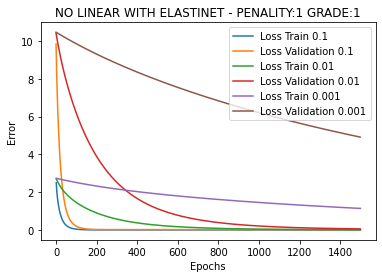

In [ ]:
# plotting of loss by iterations


learning = [ 0.1, 0.01, 0.001]
all_loss = []
all_val_loss = []
all_ssr = []
all_r_2 = []
for alfa in learning:
  w, loss, loss_val = train(x_norm, y_norm, x_val_norm, y_val_norm, 1500, alfa, penal,"ELA")
  epochs = [i + 1 for i in range(len(loss))]
  plt.title("NO LINEAR WITH ELASTINET - PENALITY:"+str(penal)+" GRADE:"+str(grade_pol))
  plt.plot(epochs,loss,loss_val)
  all_loss.append("Loss Train " + str(alfa))
  all_loss.append("Loss Validation "+str(alfa))
  SSR = ((y_test-h(x_test,w))**2).sum()
  SST = ((y_test-y_test.mean())**2).sum()
  all_r_2.append(1-(SSR/SST))
  all_ssr.append(mean_squared_error(y_test_norm, h(x_test_norm,w)))
plt.legend(all_loss)
plt.xlabel("Epochs")
plt.ylabel("Error")

for i in range(len(all_ssr)):
  print("RMSE of", str(learning[i]) ,":",all_ssr[i])
  print("R2 of", str(learning[i]) ,":",all_r_2[i])
  

In [ ]:
print(w)

In [ ]:
learning = [0.1, 0.01, 0.001]
all_loss = []
all_val_loss = []
all_r_2 = []
all_ssr = []

plt.clf()
for alfa in learning:
  w, loss, loss_val = train(x_norm, y_norm, x_val_norm, y_val_norm, 1500, alfa, penal,"RID")
  epochs = [i + 1 for i in range(len(loss))]
  plt.title("NO LINEAR WITH RIDGE - PENALITY:"+str(penal)+" GRADE:"+str(grade_pol))
  plt.plot(epochs,loss,loss_val)
  all_loss.append("Loss Train " + str(alfa))
  all_loss.append("Loss Validation "+str(alfa))
  SSR = ((y_test-h(x_test,w))**2).sum()
  SST = ((y_test-y_test.mean())**2).sum()
  all_r_2.append(1-(SSR/SST))
  all_ssr.append(SSR)
plt.legend(all_loss)
plt.xlabel("Epochs")
plt.ylabel("Error")
for i in range(len(all_ssr)):
  print("RMSE of", str(learning[i]) ,":",all_ssr[i])
  print("R2 of", str(learning[i]) ,":",all_r_2[i])

In [ ]:
learning = [0.1, 0.01, 0.001]
all_loss = []
all_val_loss = []
all_r_2 = []
all_ssr = []
plt.clf()
for alfa in learning:
  w, loss, loss_val = train(x_norm, y_norm, x_val_norm, y_val_norm, 150, alfa, penal,"LAS")
  epochs = [i + 1 for i in range(len(loss))]
  plt.title("NO LINEAR WITH LASSO - PENALITY:"+str(penal)+" GRADE:"+str(grade_pol))
  plt.plot(epochs,loss,loss_val)
  all_loss.append("Loss Train " + str(alfa))
  all_loss.append("Loss Validation "+str(alfa))
  SSR = ((y_test-h(x_test,w))**2).sum()
  SST = ((y_test-y_test.mean())**2).sum()
  all_r_2.append(1-(SSR/SST))
  all_ssr.append(SSR)
plt.legend(all_loss)
plt.xlabel("Epochs")
plt.ylabel("Error")

In [ ]:
for i in range(len(all_ssr)):
  print("RMSE of", str(learning[i]) ,":",all_ssr[i]/y_test.shape[0])
  print("R2 of", str(learning[i]) ,":",all_r_2[i])

In [ ]:
#Extracted from:
#https://www.pythonfixing.com/2022/03/fixed-multivariate-polynomial.html
#for comparison purposes
poly = PolynomialFeatures(degree=1)
poly_variables = poly.fit_transform(x)
poly.fit(poly_variables,y)
poly.fit(poly_variables,x_test)

poly_var_train, poly_var_test, res_train, res_test = train_test_split(poly_variables, y, test_size = 0.3, random_state = 4)

regression = LinearRegression()

model = regression.fit(poly_var_train, res_train)
score = model.score(poly_var_test, res_test)
y_pred = model.predict(x_test)
print(model.coef_)
print("The RMSE:",mean_squared_error(y_test, y_pred))
print("The R²:",r2_score(y_test, y_pred))
